# Exploratory Data Analysis (EDA)

```

Tahap ini bertujuan untuk memahami karakteristik dataset barcode detection yang akan digunakan
dalam proses pelatihan model. Analisis ini mencakup distribusi gambar, label, ukuran bounding box, dan contoh visualisasi data.

```

# Inmport Libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

from PIL import UnidentifiedImageError
from matplotlib import patches
from pathlib import Path
from PIL import Image
from collections import Counter

### EDA 1 - Cek Struktur Dataset dan Distribusi Gambar per Split

In [2]:
# Path utama folder dataset
image_dir = "dataset/images"

# Inisialisasi dictionary untuk menyimpan info per split
split_info = {"train": [], "val": [], "test": []}

# Loop semua file gambar dan kelompokkan berdasarkan split
for root, dirs, files in os.walk(image_dir):
    for f in files:
        if f.endswith(
            (".JPG", ".jpg", ".png", ".jpeg")
        ):  # tambahkan semua kemungkinan format
            path = os.path.join(root, f)

            # Deteksi split (train, val, test) dari path
            for split in split_info.keys():
                if f"/{split}/" in path.replace("\\", "/"):
                    with Image.open(path) as img:
                        width, height = img.size
                        split_info[split].append(
                            {
                                "filepath": path,
                                "filename": f,
                                "width": width,
                                "height": height,
                            }
                        )
                    break  # lanjut ke file berikutnya

# Konversi jadi DataFrame
df_train = pd.DataFrame(split_info["train"])
df_val = pd.DataFrame(split_info["val"])
df_test = pd.DataFrame(split_info["test"])

# Buat ringkasan
summary = pd.DataFrame(
    {
        "Split": ["Train", "Validation", "Test"],
        "Images": [len(df_train), len(df_val), len(df_test)],
        "Avg Width": [
            df_train["width"].mean(),
            df_val["width"].mean(),
            df_test["width"].mean(),
        ],
        "Avg Height": [
            df_train["height"].mean(),
            df_val["height"].mean(),
            df_test["height"].mean(),
        ],
    }
)

print("Ringkasan Dataset:")
display(summary)

Ringkasan Dataset:


,Split,Images,Avg Width,Avg Height
0,Train,694,783.976945,653.348703
1,Validation,87,729.379310,632.459770
2,Test,87,799.632184,661.885057


- Dataset terbagi menjadi tiga subset: train, val, dan test.
- Rasio data cukup seimbang, dengan sebagian besar gambar digunakan untuk pelatihan.

### EDA 2 - Distribusi Label per Split

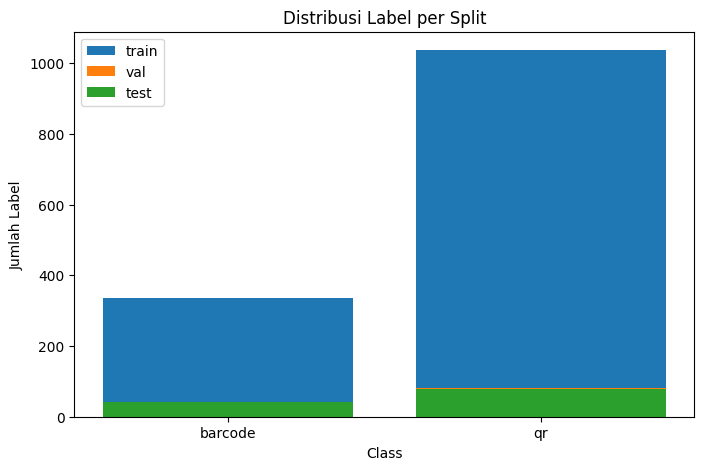

,split,class_id,count,class_name
0,train,0,335,barcode
1,train,1,1037,qr
2,val,0,36,barcode
3,val,1,81,qr
4,test,0,41,barcode
5,test,1,79,qr


In [3]:
# Path label folder
label_dir = Path("dataset/labels")

splits = ["train", "val", "test"]
label_counts = []

# Loop tiap split
for split in splits:
    split_path = label_dir / split
    label_list = []

    for file in split_path.glob("*.txt"):
        with open(file, "r") as f:
            for line in f.readlines():
                cls = int(line.strip().split()[0])  # ambil class ID
                label_list.append(cls)

    counts = Counter(label_list)
    for k, v in counts.items():
        label_counts.append({"split": split, "class_id": k, "count": v})

df_labels = pd.DataFrame(label_counts)

# Mapping ID ke nama kelas
class_map = {0: "barcode", 1: "qr"}
df_labels["class_name"] = df_labels["class_id"].map(class_map)

# Plot
plt.figure(figsize=(8, 5))
for split in splits:
    subset = df_labels[df_labels["split"] == split]
    plt.bar(subset["class_name"], subset["count"], label=split)

plt.title("Distribusi Label per Split")
plt.xlabel("Class")
plt.ylabel("Jumlah Label")
plt.legend()
plt.show()

df_labels

Dari grafik distribusi label per split, terlihat bahwa jumlah sampel kelas qr jauh lebih banyak dibanding barcode pada semua subset data. Meskipun pembagian data antar split terlihat proporsional, ketidakseimbangan kelas ini berpotensi menyebabkan bias model terhadap kelas mayoritas. Oleh karena itu, disarankan untuk menerapkan teknik penyeimbangan data atau menggunakan metrik evaluasi tambahan nantinya.

### EDA 3 - Distribusi Jumlah Label per Gambar

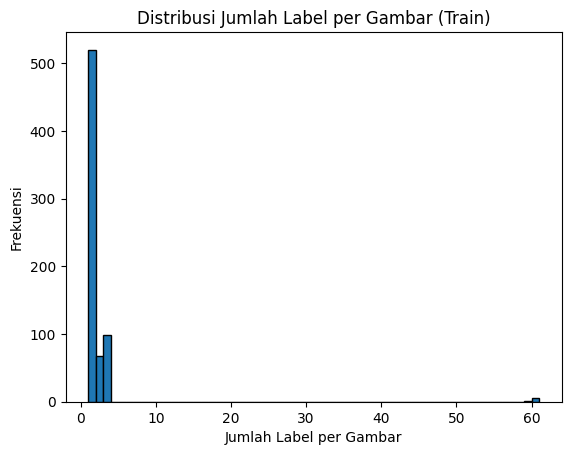

Rata-rata label per gambar: 1.98


In [4]:
# Hitung jumlah label per gambar (train)
train_labels = list((label_dir / "train").glob("*.txt"))
counts_per_img = [len(open(f).readlines()) for f in train_labels]

plt.hist(counts_per_img, bins=range(1, max(counts_per_img) + 2), edgecolor="black")
plt.title("Distribusi Jumlah Label per Gambar (Train)")
plt.xlabel("Jumlah Label per Gambar")
plt.ylabel("Frekuensi")
plt.show()

print(f"Rata-rata label per gambar: {np.mean(counts_per_img):.2f}")

Berdasarkan distribusi jumlah label per gambar pada data train, terlihat bahwa sebagian besar gambar hanya memiliki satu label, menunjukkan bahwa dataset didominasi oleh kasus single-label. Namun, terdapat sejumlah kecil outlier dengan jumlah label yang sangat tinggi (hingga sekitar 60 label), yang berpotensi menunjukkan adanya kesalahan anotasi atau gambar dengan tingkat kompleksitas tinggi. Kondisi ini perlu diperhatikan karena dapat memengaruhi keseimbangan dan stabilitas pelatihan model.

### EDA 4 - Analisis Ukuran Bounding Box

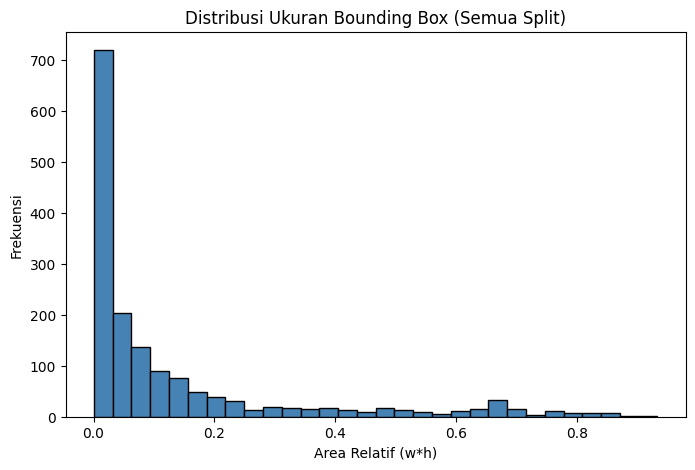

Rata-rata area bbox: 0.1322


In [ ]:
bbox_sizes = []

# Loop setiap split (train, val, test)
for split in splits:
    for file in (label_dir / split).glob("*.txt"):
        with open(file, "r") as f:
            for line in f:
                _, x, y, w, h = map(float, line.strip().split())
                bbox_sizes.append(w * h)  # area relatif

# Visualisasi distribusi ukuran bbox
plt.figure(figsize=(8, 5))
plt.hist(bbox_sizes, bins=30, color="steelblue", edgecolor="black")
plt.title("Distribusi Ukuran Bounding Box (Semua Split)")
plt.xlabel("Area Relatif (w*h)")
plt.ylabel("Frekuensi")
plt.show()

# Menampilkan rata-rata area bounding box
print(f"Rata-rata area bbox: {np.mean(bbox_sizes):.4f}")

Berdasarkan distribusi ukuran bounding box, sebagian besar objek memiliki area relatif kecil (w*h < 0.1), menunjukkan bahwa mayoritas objek di dataset berukuran kecil dibandingkan ukuran gambar. Distribusi yang sangat miring ke kanan mengindikasikan adanya ketimpangan ukuran, di mana hanya sebagian kecil bounding box berukuran sedang hingga besar. Kondisi ini perlu diperhatikan karena model deteksi objek harus mampu mengenali objek kecil dengan baik. Penyesuaian anchor box atau penerapan teknik multi-scale training dapat membantu meningkatkan performa deteksi.

### EDA 5 - Rasio Bounding Box (Lebar/Tinggi)

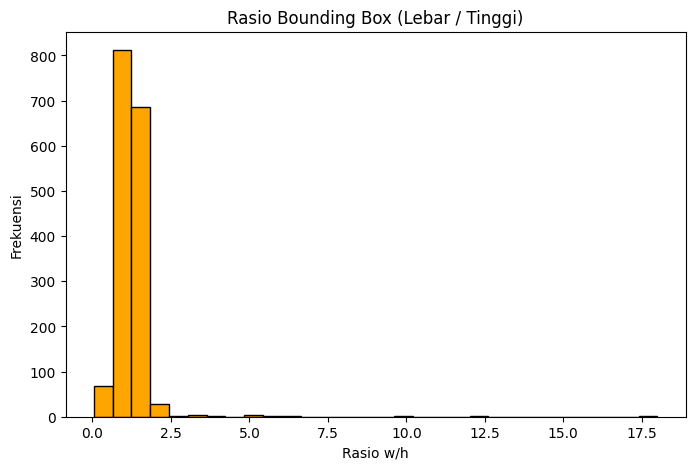

Rata-rata rasio bbox: 1.23


In [ ]:
ratios = []

# Loop setiap split untuk membaca file label
for split in splits:
    for file in (label_dir / split).glob("*.txt"):
        with open(file, "r") as f:
            for line in f:
                # Ambil lebar dan tinggi untuk menghitung rasio w/h
                _, x, y, w, h = map(float, line.strip().split())
                ratios.append(w / h)

# Visualisasi distribusi rasio bounding box
plt.figure(figsize=(8, 5))
plt.hist(ratios, bins=30, color="orange", edgecolor="black")
plt.title("Rasio Bounding Box (Lebar / Tinggi)")
plt.xlabel("Rasio w/h")
plt.ylabel("Frekuensi")
plt.show()

# Cetak nilai rata-rata rasio
print(f"Rata-rata rasio bbox: {np.mean(ratios):.2f}")

Berdasarkan distribusi rasio bounding box (lebar/tinggi), sebagian besar objek memiliki rasio antara 0.5 - 2.0, menunjukkan bahwa mayoritas objek berbentuk persegi atau mendekati persegi. Namun, terdapat sejumlah kecil outlier dengan rasio ekstrem >5, yang mungkin disebabkan oleh variasi alami bentuk objek atau kesalahan anotasi. Distribusi ini menunjukkan pentingnya penyesuaian anchor box agar model mampu mendeteksi objek dengan berbagai proporsi secara optimal.

### EDA 6 - Contoh Visualisasi Bounding Box (Sample Preview)

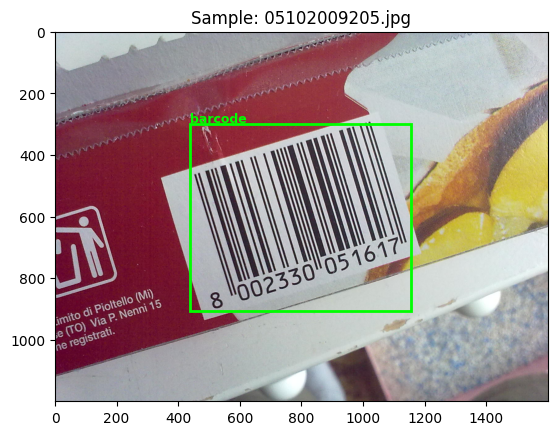

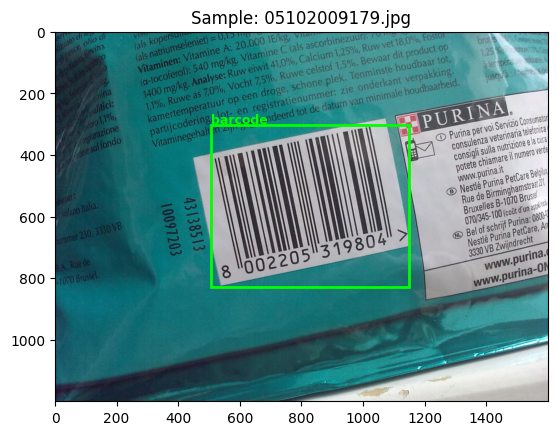

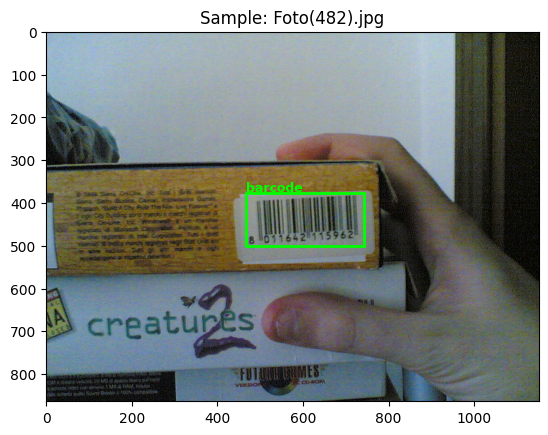

In [ ]:
def visualize_sample(split="train", n=3):
    """
    Fungsi untuk menampilkan beberapa contoh gambar beserta bounding box hasil anotasi.
    split: menentukan subset (train/val/test)
    n: jumlah gambar yang akan ditampilkan
    """
    img_dir = Path(f"dataset/images/{split}")
    label_dir_split = Path(f"dataset/labels/{split}")

    # Pilih n gambar acak dari folder split
    sample_files = random.sample(list(img_dir.glob("*.JPG")), n)

    for img_path in sample_files:
        label_path = label_dir_split / (img_path.stem + ".txt")

        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        fig, ax = plt.subplots(1)
        ax.imshow(img)
        # Jika label ada, gambar bounding box di atas gambar
        if label_path.exists():
            with open(label_path, "r") as f:
                for line in f:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    x1 = (x - bw / 2) * w
                    y1 = (y - bh / 2) * h
                    bw *= w
                    bh *= h
                    rect = patches.Rectangle(
                        (x1, y1),
                        bw,
                        bh,
                        linewidth=2,
                        edgecolor="lime",
                        facecolor="none",
                    )
                    ax.add_patch(rect)
                    # Tambahkan teks label kelas di atas kotak
                    ax.text(
                        x1,
                        y1 - 5,
                        class_map[int(cls)],
                        color="lime",
                        fontsize=9,
                        weight="bold",
                    )
        plt.title(f"Sample: {img_path.name}")
        plt.show()

# Jalankan fungsi visualisasi
visualize_sample("train", n=3)

Berdasarkan visualisasi sampel anotasi, bounding box terlihat akurat dan konsisten dengan posisi objek barcode maupun QR code. Dataset mencakup variasi bentuk (persegi dan persegi panjang), orientasi (tegak dan miring), serta kondisi pencahayaan (terang hingga redup). Beberapa gambar juga mengandung lebih dari satu objek, menunjukkan dukungan terhadap deteksi multi-objek. Secara keseluruhan, kualitas anotasi dan keragaman visual sudah baik, meskipun augmentasi tambahan dapat dipertimbangkan untuk meningkatkan robustnes model.

### EDA 7 - Distribusi Jumlah Objek per Gambar

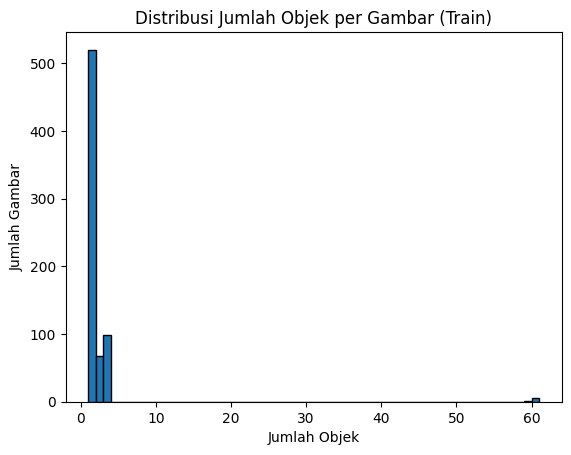

In [ ]:
def count_objects_per_image(label_dir):
    """
    Fungsi untuk menghitung jumlah objek (baris label) pada setiap gambar.
    """
    counts = []
    for file in Path(label_dir).glob("*.txt"):
        with open(file, "r") as f:
            lines = f.readlines()
            counts.append(len(lines))
    return counts

# Hitung jumlah objek per gambar untuk train set
train_counts = count_objects_per_image("dataset/labels/train")

# Plot histogram jumlah objek
plt.hist(train_counts, bins=range(1, max(train_counts) + 2), edgecolor="black")
plt.title("Distribusi Jumlah Objek per Gambar (Train)")
plt.xlabel("Jumlah Objek")
plt.ylabel("Jumlah Gambar")
plt.show()

Berdasarkan distribusi jumlah objek per gambar, mayoritas citra pada dataset train hanya mengandung satu objek barcode atau QR code. Hanya sebagian kecil citra yang memuat lebih dari satu objek, dan terdapat satu outlier dengan jumlah objek sangat banyak (60). Distribusi ini menunjukkan bahwa dataset cenderung tidak seimbang dalam hal jumlah objek per gambar.

### EDA 8 - Cek Keseimbangan antara Split Dataset

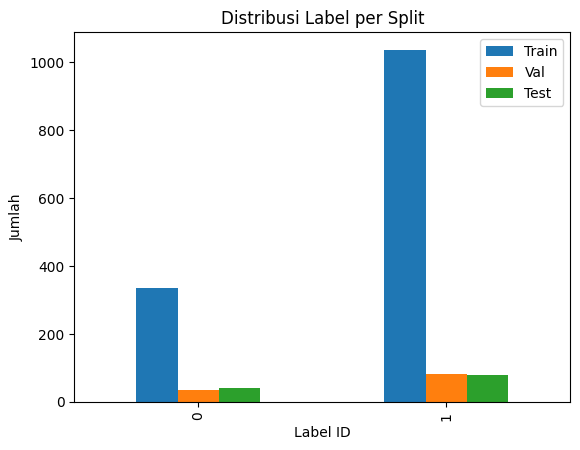

In [ ]:
def get_label_counts(label_dir):
    """
    Fungsi untuk menghitung jumlah kemunculan setiap label (class_id) di folder label.
    """
    labels = []
    for file in Path(label_dir).glob("*.txt"):
        with open(file, "r") as f:
            for line in f.readlines():
                label_id = int(line.split()[0])
                labels.append(label_id)
    return pd.Series(labels).value_counts().sort_index()

# Hitung jumlah label per split
train_counts = get_label_counts("dataset/labels/train")
val_counts = get_label_counts("dataset/labels/val")
test_counts = get_label_counts("dataset/labels/test")

# Gabungkan jadi satu dataframe
df_split_dist = pd.DataFrame(
    {"Train": train_counts, "Val": val_counts, "Test": test_counts}
).fillna(0)

# Plot perbandingan distribusi label antar split
df_split_dist.plot(kind="bar")
plt.title("Distribusi Label per Split")
plt.xlabel("Label ID")
plt.ylabel("Jumlah")
plt.show()

Distribusi label menunjukkan adanya ketidakseimbangan antara dua kelas, di mana label 1 jauh lebih banyak dibanding label 0 terutama pada data train. Meski begitu, distribusi pada validation dan test relatif seimbang, sehingga tetap representatif untuk evaluasi performa model. Ketidakseimbangan pada data train dapat menyebabkan model lebih fokus ke kelas mayoritas, sehingga diperlukan strategi seperti augmentasi tambahan pada kelas minoritas atau penerapan class weighting.

### EDA 9 - Cek Kualitas File / Error Detection

In [ ]:
def check_corrupted_images(image_dir):
    """
    Fungsi untuk mendeteksi gambar yang corrupt atau tidak bisa dibuka.
    """
    corrupted = []
    for file in Path(image_dir).rglob("*.jpg"):
        try:
            img = Image.open(file)
            img.verify()
        except (UnidentifiedImageError, OSError):
            corrupted.append(str(file))
    return corrupted

# Jalankan pengecekan pada dataset train
corrupted_images = check_corrupted_images("dataset/images/train")
print(f"Jumlah gambar corrupt: {len(corrupted_images)}")
if corrupted_images:
    print(corrupted_images[:5])

Jumlah gambar corrupt: 0


Hasil pemeriksaan menunjukkan tidak ada gambar yang corrupt pada dataset train. Ini menandakan bahwa seluruh data gambar dapat diakses dengan baik dan siap digunakan untuk proses pelatihan tanpa perlu perbaikan tambahan.

### EDA 10 - Distribusi Ukuran Bounding Box (Normalisasi YOLO)

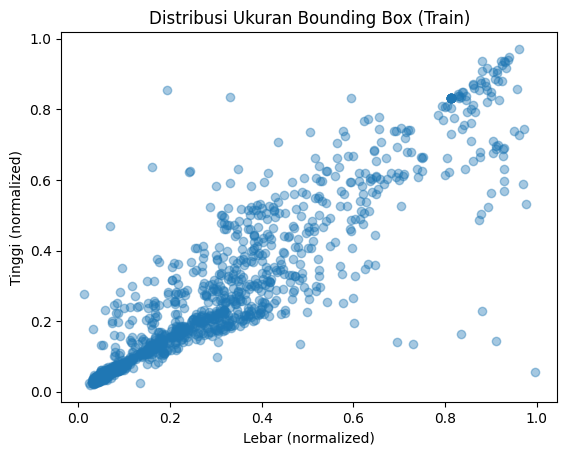

In [ ]:
def get_box_sizes(label_dir):
    """
    Fungsi untuk mengambil lebar dan tinggi bounding box dari file label YOLO.
    """
    widths, heights = [], []
    for file in Path(label_dir).glob("*.txt"):
        with open(file, "r") as f:
            for line in f.readlines():
                _, x_center, y_center, w, h = map(float, line.strip().split())
                widths.append(w)
                heights.append(h)
    return np.array(widths), np.array(heights)

# Ambil data bounding box dari train set
w, h = get_box_sizes("dataset/labels/train")

# Scatter plot antara lebar dan tinggi bounding box
plt.scatter(w, h, alpha=0.4)
plt.title("Distribusi Ukuran Bounding Box (Train)")
plt.xlabel("Lebar (normalized)")
plt.ylabel("Tinggi (normalized)")
plt.show()

Sebagian besar bounding box memiliki ukuran kecil hingga sedang (nilai normalisasi < 0.3) dengan korelasi positif antara lebar dan tinggi. Hal ini menunjukkan bahwa objek dalam dataset umumnya proporsional dan tidak terlalu mendominasi gambar. Namun, terdapat beberapa objek berukuran besar yang berperan sebagai variasi penting bagi model deteksi.